In [18]:
# porto_seguro_insur.py
#  Assumes python vers. 3.6
# __author__ = 'mizio'

import csv as csv
import numpy as np
import pandas as pd
import pylab as plt
from fancyimpute import MICE
import random
from sklearn.model_selection import cross_val_score
import datetime
import seaborn as sns
import tensorflow as tf

In [9]:
class PortoSeguroInsur:
    def __init__(self):
        self.df = PortoSeguroInsur.df
        self.df_test = PortoSeguroInsur.df_test
        self.df_submission = PortoSeguroInsur.df_submission
        self.timestamp = datetime.datetime.now().strftime('%Y%m%d_%Hh%Mm%Ss')


    # Load data into Pandas DataFrame
    # For .read_csv, always use header=0 when you know row 0 is the header row
    df = pd.read_csv('../input/train.csv', header=0)
    df_test = pd.read_csv('../input/test.csv', header=0)
    df_submission = pd.read_csv('../input/sample_submission.csv', header=0)

    @staticmethod
    def features_with_null_logical(df, axis=1):
        row_length = len(df._get_axis(0))
        # Axis to count non null values in. aggregate_axis=0 implies counting for every feature
        aggregate_axis = 1 - axis
        features_non_null_series = df.count(axis=aggregate_axis)
        # Whenever count() differs from row_length it implies a null value exists in feature column and a False in mask
        mask = row_length == features_non_null_series
        return mask

    def missing_values_in_dataframe(self, df):
        mask = self.features_with_null_logical(df)
        print(df[mask[mask == 0].index.values].isnull().sum())
        print('\n')

    @staticmethod
    def extract_numerical_features(df):
        df = df.copy()
        df = df.copy()
        non_numerical_feature_names = df.columns[np.where(PortoSeguroInsur.numerical_feature_logical_incl_hidden_num(
            df) == 0)]
        return non_numerical_feature_names

    @staticmethod
    def extract_non_numerical_features(df):
        df = df.copy()
        non_numerical_feature_names = df.columns[np.where(PortoSeguroInsur.numerical_feature_logical_incl_hidden_num(
            df))]
        return non_numerical_feature_names

    @staticmethod
    def numerical_feature_logical_incl_hidden_num(df):
        logical_of_non_numeric_features = np.zeros(df.columns.shape[0], dtype=int)
        for ite in np.arange(0, df.columns.shape[0]):
            try:
                str(df[df.columns[ite]][0]) + df[df.columns[ite]][0]
                logical_of_non_numeric_features[ite] = True
            except TypeError:
                hej = 'Oops'
        return logical_of_non_numeric_features

    def clean_data(self, df, is_train_data=1):
        df = df.copy()
        if df.isnull().sum().sum() > 0:
            if is_train_data:
                df = df.dropna()
            else:
                df = df.dropna(1)
        return df

    def reformat_data(self, labels, num_labels):
        # Map labels/target value to one-hot-encoded frame. None is same as implying newaxis() just replicating array
        # if num_labels > 2:
        labels = (np.arange(num_labels) == labels[:, None]).astype(np.float64)
        return labels

    def accuracy(self, predictions, labels):
        # Sum the number of cases where the predictions are correct and divide by the number of predictions
        number_of_correct_predictions = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
        return 100*number_of_correct_predictions/predictions.shape[0]

    def linear_model(self, input_vector, weight_matrix, bias_vector):
        # f(x) = Wx + b
        # W is the weight matrix with elements w_ij
        # x is the input vector
        # b is the bias vector
        # In the machine learning literature f(x) is called an activation
        return tf.matmul(input_vector, weight_matrix) + bias_vector

    def activation_out(self, logit):
        return self.activation(logit, switch_var=0)

    def activation_hidden(self, logit):
        return self.activation(logit, switch_var=0)

    def activation(self, logit, switch_var=0):
        # Also called the activation function
        if switch_var == 0:
            # Logistic sigmoid function.
            # sigma(a) = 1/(1+exp(-a))
            return tf.nn.sigmoid(logit)
        elif switch_var == 1:
            # Using Rectifier as activation function. Rectified linear unit (ReLU). Compared to sigmoid or other
            # activation functions it allows for faster and effective training of neural architectures.
            # f(x) = max(x,0)
            return tf.nn.relu(logit)
        else:
            # Softmax function.
            # S(y_i) = e^y_i/(Sum_j e^y_j)
            return tf.nn.softmax(logit)

    def missing_values_in_dataframe(self, df):
        mask = self.features_with_null_logical(df)
        print(df[mask[mask == 0].index.values].isnull().sum())
        print('\n')
        
    @staticmethod
    def extract_numerical_features(df):
        df = df.copy()
        # Identify numerical columns which are of type object
        numerical_features = pd.Series(data=False, index=df.columns, dtype=bool)

        for feature in df.columns:
            if any(tuple(df[feature].apply(lambda x: type(x)) == int)) or \
                            any(tuple(df[feature].apply(lambda x: type(x)) == float)) & \
                            (not any(tuple(df[feature].apply(lambda x: type(x)) == str))):
                numerical_features[feature] = 1
        return numerical_features[numerical_features == 1].index


In [12]:
porto_seguro_insur = PortoSeguroInsur()
df = porto_seguro_insur.df.copy()
df_test = porto_seguro_insur.df_test.copy()
df_submission = porto_seguro_insur.df_submission.copy()

df = df.replace(-1, np.NaN)
df_test = df_test.replace(-1, np.NaN)

print('All df set missing values')
porto_seguro_insur.missing_values_in_dataframe(df)

# Train Data: numeric feature columns with none or nan in test data
print('\nColumns in train data with none/nan values:')
print('\nTraining set numerical features\' missing values')
df_numerical_features = porto_seguro_insur.extract_numerical_features(df)
print('\nNumber of numerical features df: %s' % df_numerical_features.shape[0])
porto_seguro_insur.missing_values_in_dataframe(df[df_numerical_features])

# Test Data: Print numeric feature columns with none/nan in test data
print('\nColumns in test data with none/nan values:')
print('\nTest set numerical features\' missing values')
df_test_numerical_features = porto_seguro_insur.extract_numerical_features(df_test)
print('\nNumber of numerical features df_test: %s' % df_test_numerical_features.shape[0])
porto_seguro_insur.missing_values_in_dataframe(df_test[df_test_numerical_features])

print(df.shape)
print(df_test.shape)
# Clean data for NaN
df = porto_seguro_insur.clean_data(df)
df_test = porto_seguro_insur.clean_data(df_test, is_train_data=0)
print('df_test.shape: %s' % str(df_test.shape))  # (892816, 46)
# df_test = porto_seguro_insur.clean_data(df_test, is_train_data=0)
id_df_test = df_test['id']  # Submission column
print("After dropping NaN")
print(df.shape)
print(df_test.shape)

All df set missing values
ps_ind_02_cat       216
ps_ind_04_cat        83
ps_ind_05_cat      5809
ps_reg_03        107772
ps_car_01_cat       107
ps_car_02_cat         5
ps_car_03_cat    411231
ps_car_05_cat    266551
ps_car_07_cat     11489
ps_car_09_cat       569
ps_car_11             5
ps_car_12             1
ps_car_14         42620
dtype: int64



Columns in train data with none/nan values:

Training set numerical features' missing values

Number of numerical features df: 59
ps_ind_02_cat       216
ps_ind_04_cat        83
ps_ind_05_cat      5809
ps_reg_03        107772
ps_car_01_cat       107
ps_car_02_cat         5
ps_car_03_cat    411231
ps_car_05_cat    266551
ps_car_07_cat     11489
ps_car_09_cat       569
ps_car_11             5
ps_car_12             1
ps_car_14         42620
dtype: int64



Columns in test data with none/nan values:

Test set numerical features' missing values

Number of numerical features df_test: 58
ps_ind_02_cat       307
ps_ind_04_cat       145
ps_ind_05_

In [4]:
is_explore_data = 1
if is_explore_data:
    # Overview of train data
    print('\n TRAINING DATA:----------------------------------------------- \n')
    print(df.head(3))
    print('\n')
    print(df.info())
    print('\n')
    print(df.describe())
    print('\n')
    print(df.dtypes)
    print(df.get_dtype_counts())

    # missing_values
    print('All df set missing values')
    porto_seguro_insur.missing_values_in_dataframe(df)

    print('Uniques')
    uniques_in_id = np.unique(df.id.values).shape[0]
    print(uniques_in_id)
    print('uniques_in_id == df.shape[0]')
    print(uniques_in_id == df.shape[0])

    # Overview of sample_submission format
    print('\n sample_submission \n')
    print(df_submission.head(3))
    print('\n')
    print(df_submission.info())
    print('\n')


 TRAINING DATA:----------------------------------------------- 

   id  target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
3  16       0          0            1.0          2            0.0   
7  22       0          5            1.0          4            0.0   
9  28       1          1            1.0          2            0.0   

   ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin       ...        \
3            0.0              1              0              0       ...         
7            0.0              1              0              0       ...         
9            0.0              0              1              0       ...         

   ps_calc_11  ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  \
3           2           2           4           9               0   
7           7           1           3           6               1   
9           3           5           0           6               0   

   ps_calc_16_bin  ps_calc_17_bin  ps_calc_18_bin  ps_c


Correlations in training data


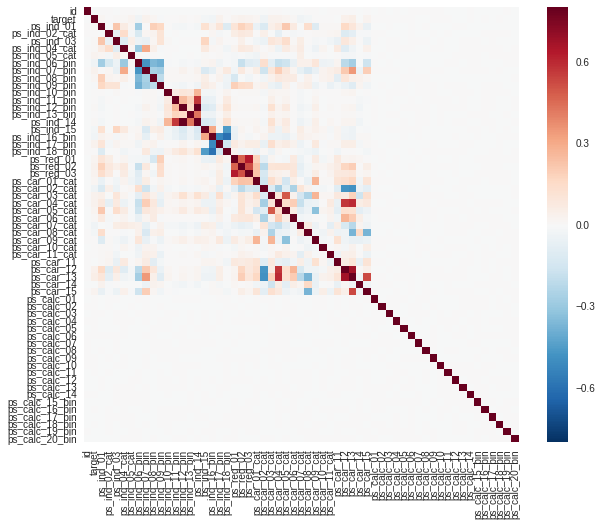


Correlations in test data


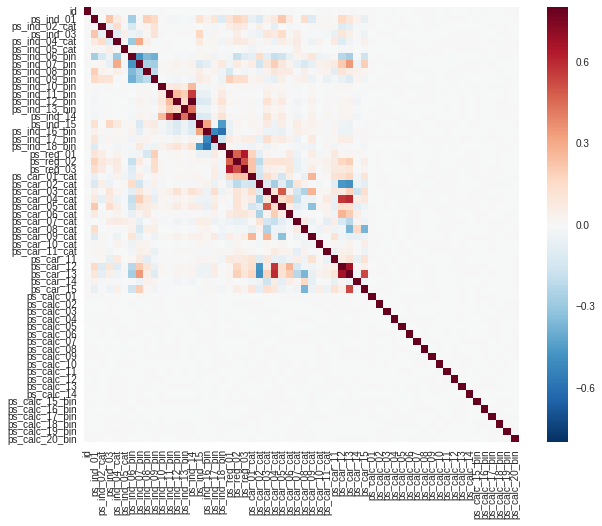

In [23]:
# Categorical plot with seaborn
is_categorical_plot = 1
if is_categorical_plot:
    # sns.countplot(y='MSZoning', hue='MSSubClass', data=df, palette='Greens_d')
    # plt.show()
    # sns.stripplot(x='SalePrice', y='MSZoning', data=df, jitter=True, hue='LandContour')
    # plt.show()
    # sns.boxplot(x='SalePrice', y='MSZoning', data=df, hue='MSSubClass')
    # plt.show()

    # Heatmap of feature correlations
    print('\nCorrelations in training data')
    plt.figure(figsize=(10, 8))
    correlations_train = porto_seguro_insur.df.corr()
    sns.heatmap(correlations_train, vmax=0.8, square=True)
    plt.show()
    
    # Heatmap of feature correlations
    print('\nCorrelations in test data')
    plt.figure(figsize=(10, 8))
    correlations_test = porto_seguro_insur.df_test.corr()
    sns.heatmap(correlations_test, vmax=0.8, square=True)
    plt.show()

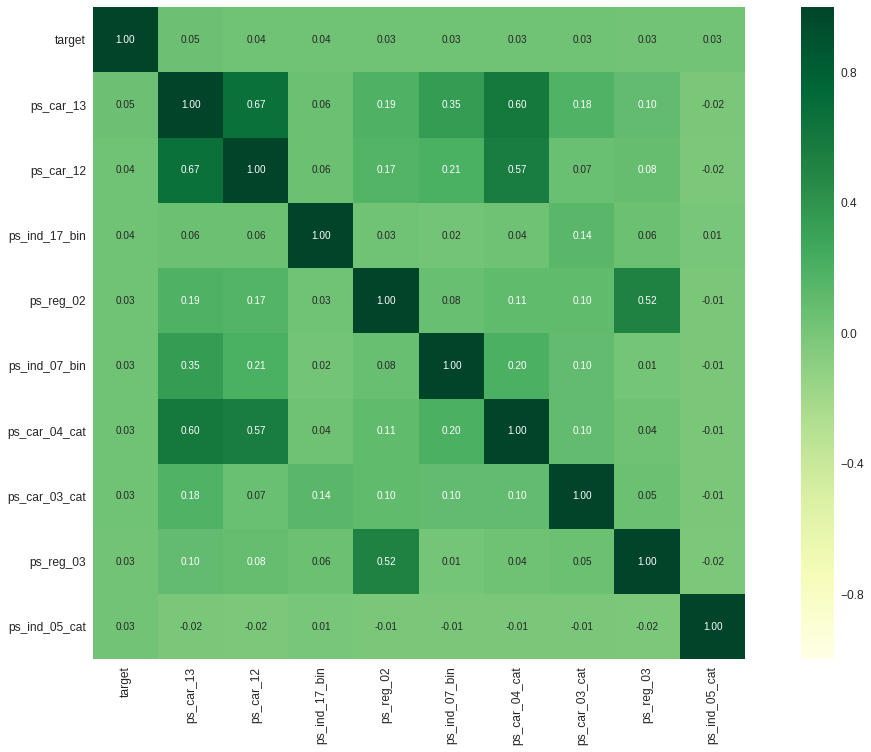

In [24]:
# Zoom of heatmap with coefficients
plt.figure(figsize=(20, 12))
top_features = 10
columns = correlations_train.nlargest(top_features, 'target')['target'].index
correlation_coeff = np.corrcoef(porto_seguro_insur.df[columns].values.T)
sns.set(font_scale=1.20)
coeff_heatmap = sns.heatmap(correlation_coeff, annot=True, cmap='YlGn', cbar=True, 
                            square=True, fmt='.2f', annot_kws={'size': 10}, 
                            yticklabels=columns.values, xticklabels=columns.values)
plt.show()

Note that correlations with target are low. The best features are ps_car_13 and ps_car_12.
Check if there are categorical features that need to be one-hot-encoded.
Example note that in features we have,
ps_ind_02_cat
and
ps_ind_06_bin
where 'cat' and 'bin' may be abbreviations for categorical and binary feature values.

In [70]:
# Check output space for each feature. Expect 58 uniques i.e. one for every feature.
ser_with_uniques = pd.Series()
for ite in df.columns:
    ser_with_uniques[ite] = df[ite].unique().shape[0]
print(ser_with_uniques)

id                124931
target                 2
ps_ind_01              8
ps_ind_02_cat          4
ps_ind_03             12
ps_ind_04_cat          2
ps_ind_05_cat          7
ps_ind_06_bin          2
ps_ind_07_bin          2
ps_ind_08_bin          2
ps_ind_09_bin          2
ps_ind_10_bin          2
ps_ind_11_bin          2
ps_ind_12_bin          2
ps_ind_13_bin          2
ps_ind_14              5
ps_ind_15             14
ps_ind_16_bin          2
ps_ind_17_bin          2
ps_ind_18_bin          2
ps_reg_01             10
ps_reg_02             19
ps_reg_03           4799
ps_car_01_cat         12
ps_car_02_cat          2
ps_car_03_cat          2
ps_car_04_cat         10
ps_car_05_cat          2
ps_car_06_cat         18
ps_car_07_cat          2
ps_car_08_cat          2
ps_car_09_cat          5
ps_car_10_cat          3
ps_car_11_cat        101
ps_car_11              4
ps_car_12            141
ps_car_13          34041
ps_car_14            522
ps_car_15             15
ps_calc_01            10


In [72]:
# Check if two-value features are binaries
indices_of_two_value_feats = ser_with_uniques == 2
print(indices_of_two_value_feats)

id                False
target             True
ps_ind_01         False
ps_ind_02_cat     False
ps_ind_03         False
ps_ind_04_cat      True
ps_ind_05_cat     False
ps_ind_06_bin      True
ps_ind_07_bin      True
ps_ind_08_bin      True
ps_ind_09_bin      True
ps_ind_10_bin      True
ps_ind_11_bin      True
ps_ind_12_bin      True
ps_ind_13_bin      True
ps_ind_14         False
ps_ind_15         False
ps_ind_16_bin      True
ps_ind_17_bin      True
ps_ind_18_bin      True
ps_reg_01         False
ps_reg_02         False
ps_reg_03         False
ps_car_01_cat     False
ps_car_02_cat      True
ps_car_03_cat      True
ps_car_04_cat     False
ps_car_05_cat      True
ps_car_06_cat     False
ps_car_07_cat      True
ps_car_08_cat      True
ps_car_09_cat     False
ps_car_10_cat     False
ps_car_11_cat     False
ps_car_11         False
ps_car_12         False
ps_car_13         False
ps_car_14         False
ps_car_15         False
ps_calc_01        False
ps_calc_02        False
ps_calc_03      

In [87]:
feats_with_two_value = ser_with_uniques[indices_of_two_value_feats]
print(feats_with_two_value.axes[0])
print(type(feats_with_two_value.axes))

Index(['target', 'ps_ind_04_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin',
       'ps_ind_18_bin', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_calc_15_bin', 'ps_calc_16_bin',
       'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin'],
      dtype='object')
<class 'list'>


In [93]:
ser_with_max_of_uniques = pd.Series()
for ite in feats_with_two_value.axes[0]:
    ser_with_max_of_uniques[ite] = df[ite].unique()
print(ser_with_max_of_uniques)

target                [0, 1]
ps_ind_04_cat     [0.0, 1.0]
ps_ind_06_bin         [1, 0]
ps_ind_07_bin         [0, 1]
ps_ind_08_bin         [0, 1]
ps_ind_09_bin         [0, 1]
ps_ind_10_bin         [0, 1]
ps_ind_11_bin         [0, 1]
ps_ind_12_bin         [0, 1]
ps_ind_13_bin         [0, 1]
ps_ind_16_bin         [1, 0]
ps_ind_17_bin         [0, 1]
ps_ind_18_bin         [0, 1]
ps_car_02_cat     [1.0, 0.0]
ps_car_03_cat     [0.0, 1.0]
ps_car_05_cat     [1.0, 0.0]
ps_car_07_cat     [1.0, 0.0]
ps_car_08_cat         [1, 0]
ps_calc_15_bin        [0, 1]
ps_calc_16_bin        [0, 1]
ps_calc_17_bin        [0, 1]
ps_calc_18_bin        [0, 1]
ps_calc_19_bin        [0, 1]
ps_calc_20_bin        [0, 1]
dtype: object


Hence the two-value features are binaries.

In [5]:
is_prepare_data = 1
if is_prepare_data:
    df_test_num_features = porto_seguro_insur.extract_numerical_features(df_test)
    df_y = df.loc[:, ['target']]
    df = df.loc[:, df_test_num_features]

is_prediction = 1
if is_prediction:
    # Subset the data to make it run faster
    # (595212, 59)
    # (892816, 58)
    # After dropping NaN
    # (124931, 59)
    # (186567, 58)
    subset_size = 20000

    num_labels = np.unique(df_y.loc[:subset_size, 'target'].values).shape[0]
    num_columns = df[(df.columns[(df.columns != 'target') & (df.columns != 'id')])].shape[1]
    # Reformat datasets
    x_train = df.loc[:subset_size, (df.columns[(df.columns != 'target') & (df.columns != 'id')])].values
    y_train = df_y.loc[:subset_size, 'target'].values
    # We only need to one-hot-encode our labels since otherwise they will not match the dimension of the
    # logits in our later computation.
    y_train = porto_seguro_insur.reformat_data(y_train, num_labels=num_labels)

    # Todo: we need testdata with labels to benchmark test results.
    # Hack. Use subset of training data (not used in training model) as test data, since it has a label/target value
    # In case there are duplicates in training data it may imply that test results are too good, when using
    # a subset of training data for test.
    # Todo: do cross-validation instead of only one subset testing as below in x_val
    # Validation data is a subset of training data.
    x_val = df.loc[subset_size:2*subset_size, (df.columns[(df.columns != 'target') & (df.columns != 'id')])].values
    y_val = df_y.loc[subset_size:2*subset_size, 'target'].values
    y_val = porto_seguro_insur.reformat_data(y_val, num_labels=num_labels)
    # Test data.
    x_test = df_test.loc[:, (df_test.columns[(df_test.columns != 'id')])].values

    # Todo: we need validation data with labels to perform crossvalidation while training and get a better result.

    # Tensorflow uses a dataflow graph to represent your computations in terms of dependencies.
    graph = tf.Graph()
    with graph.as_default():
        # Load training and test data into constants that are attached to the graph
        tf_train = tf.constant(x_train)
        tf_train_labels = tf.constant(y_train)
        tf_val = tf.constant(x_val)
        tf_test = tf.constant(x_test)

        # As in a neural network the goal is to compute the cross-entropy D(S(w,x), L)
        # x, input training data
        # w_ij, are elements of the weight matrix
        # L, labels or target values of the training data (classification problem)
        # S(), is softmax function
        # Do the Multinomial Logistic Classification
        # step 1.
        # Compute y from the linear model y = WX + b, where b is the bias and W is randomly chosen on
        # Gaussian distribution and bias is set to zero. The result is called the logit.
        # step 2.
        # Compute the softmax function S(Y) which gives distribution
        # step 3.
        # Compute cross-entropy D(S, L) = - Sum_i L_i*log(S_i)
        # step 4.
        # Compute loss L = 1/N * D(S, L)
        # step 5.
        # Use gradient-descent to find minimum of loss wrt. w and b by minimizing L(w,b).
        # Update your weight and bias until minimum of loss function is reached
        # w_i -> w_i - alpha*delta_w L
        # b -> b - alpha*delta_b L
        # OBS. step 5 is faster optimized if you have transformed the data to have zero mean and equal variance
        # mu(x_i) = 0
        # sigma(x_i) = sigma(x_j)
        # This transformation makes it a well conditioned problem.

        # Make a 2-layer Neural network (count number of layers of adaptive weights) with num_columns nodes
        # in hidden layer.
        # Initialize weights on truncated normal distribution. Initialize biases to zero.
        # For every input vector corresponding to one sample we have D features s.t.
        # a_j = Sum_i^D w^(1)_ji x_i + w^(1)_j0 , where index j is the number of nodes in the first hidden layer
        # and it runs j=1,...,M
        # Vectorizing makes the notation more compact
        #     | --- x_1 --- |
        #     | --- x_2 --- |
        # X = | --- ..  --- |
        #     | --- x_N --- |
        # where each x is now a sample vector of dimension (1 x D) and where N is the number of samples.
        # Similarly, define a tiling of N weight matrices w,
        #     | --- w --- |
        #     | --- w --- |
        # W = | --- ..--- |
        #     | --- w --- |
        # where each w is now a matrix of dimension (M x D)
        # We now form the tensor product between W and X but we need to transpose X as x.T to get (M x D).(D x 1)
        # multiplication,
        #       |  w.(x_1.T) |
        #       |  w.(x_2.T) |
        # W.X = |  ..        |
        #       |  w.(x_N.T) |
        # with W.X having dimensions (M*N x 1).
        # Additionally, define a tiling of N bias vectors b that each are of dimension (M x 1),
        #     |  b  |
        #     |  b  |
        # B = |  .. |
        #     |  b  |
        # with B having dimensions (M*N x 1).
        # Finally, the activation is a (M*N x 1) vector given as A = W.X + B.
        # Next, this is passed to an activation function like a simoid and then inserted in second layer of the NN.
        # Let Z = sigmoid(A)
        # Let C be the activation of the second layer,
        # C = W^(2).Z + B^(2)
        # where W^(2) is the tiling N second layer weight matrices w^(2) each with dimension (K x M). K is the
        # number of outputs in the classification. The dimension of C is (K x N).
        # Lastly, apply the sigmoid function to get the predictions
        # P = sigmoid( C )
        # which has dimensions (K x N) and is as expected an output vector (K x 1) for every N samples in our
        # dataset. The output (K x 1)-vector is in a one-hot-encoded form.

        # Choose number of nodes > than number of features.
        M_nodes = 2*x_train.shape[1]
        weights_1_layer = tf.Variable(tf.truncated_normal([num_columns, M_nodes], dtype=np.float64))
        biases_1_layer = tf.Variable(tf.zeros([M_nodes], dtype=np.float64))
        weights_2_layer = tf.Variable(tf.truncated_normal([M_nodes, num_labels], dtype=np.float64))
        biases_2_layer = tf.Variable(tf.zeros([num_labels], dtype=np.float64))

        # Logits and loss function.
        logits_hidden_1_layer = porto_seguro_insur.linear_model(tf_train, weights_1_layer, biases_1_layer)
        # Output unit activations of first layer
        a_1_layer = porto_seguro_insur.activation_hidden(logits_hidden_1_layer)
        logits_2_layer = porto_seguro_insur.linear_model(a_1_layer, weights_2_layer, biases_2_layer)
        switch_var = 0
        if switch_var == 1:
            loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,
                                                                                   logits=logits_2_layer))
        else:
            loss_function = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_train_labels,
                                                                                   logits=logits_2_layer))

        # Find minimum of loss function using gradient-descent.
        optimized_weights_and_bias = tf.train.GradientDescentOptimizer(0.5).minimize(loss=loss_function)

        # Accuracy variables using the initial values for weights and bias of our linear model.
        train_prediction = porto_seguro_insur.activation_out(logits_2_layer)
        # Applying optimized weights and bias to validation data
        logits_hidden_1_layer_val = porto_seguro_insur.linear_model(tf_val, weights_1_layer, biases_1_layer)
        a_1_layer_val = porto_seguro_insur.activation_hidden(logits_hidden_1_layer_val)
        logits_2_layer_val = porto_seguro_insur.linear_model(a_1_layer_val, weights_2_layer, biases_2_layer)
        val_prediction = porto_seguro_insur.activation_out(logits_2_layer_val)

        # Applying optimized weights and bias to test data
        logits_hidden_1_layer_test = porto_seguro_insur.linear_model(tf_test, weights_1_layer, biases_1_layer)
        a_1_layer_test = porto_seguro_insur.activation_hidden(logits_hidden_1_layer_test)
        logits_2_layer_test = porto_seguro_insur.linear_model(a_1_layer_test, weights_2_layer, biases_2_layer)
        test_prediction = porto_seguro_insur.activation_out(logits_2_layer_test)

    number_of_iterations = 900
    # Creating a tensorflow session to effeciently run same computation multiple times using definitions in defined
    # dataflow graph.
    with tf.Session(graph=graph) as session:
        # Ensure that variables are initialized as done in our graph defining the dataflow.
        tf.global_variables_initializer().run()
        for ite in range(number_of_iterations):
            # Compute loss and predictions
            loss, predictions = session.run([optimized_weights_and_bias, loss_function, train_prediction])[1:3]
            if ite % 100 == 0:
                print('Loss at iteration %d: %f' % (ite, loss))
                print('Training accuracy: %.1f%%' % porto_seguro_insur.accuracy(predictions, y_train))
        print('Test accuracy: %.1f%%' % porto_seguro_insur.accuracy(val_prediction.eval(), y_val))
        output = test_prediction.eval()

Loss at iteration 0: 0.477945
Training accuracy: 88.1%
Loss at iteration 100: 0.191353
Training accuracy: 95.4%
Loss at iteration 200: 0.186203
Training accuracy: 95.4%
Loss at iteration 300: 0.182868
Training accuracy: 95.4%
Loss at iteration 400: 0.180391
Training accuracy: 95.5%
Loss at iteration 500: 0.178418
Training accuracy: 95.5%
Loss at iteration 600: 0.176696
Training accuracy: 95.5%
Loss at iteration 700: 0.175110
Training accuracy: 95.5%
Loss at iteration 800: 0.173571
Training accuracy: 95.5%
Test accuracy: 95.1%


In [6]:
is_make_prediction = 1
if is_make_prediction:
    ''' Submission '''
    # Submission requires a csv file with id and target columns.
    submission = pd.DataFrame({'id': id_df_test, 'target': np.argmax(output, 1)})
    submission.to_csv(''.join(['submission_porto_seguro_insur_', porto_seguro_insur.timestamp, '.csv']), index=False)
    print(porto_seguro_insur.timestamp)

20171027_10h17m32s
